# DNA Anomaly Detection: Unsupervised LSTM Autoencoder

This notebook implements an **Unsupervised Anomaly Detection** system for DNA sequencing data.
Unlike the previous supervised approach, this model is trained **only on Normal (healthy) sequences** to learn a robust representation of "normality".
Cancerous sequences (anomalies) are detected at inference time by their high **Reconstruction Error**, as the model struggles to reconstruct patterns it has never seen.

### Pipeline:
1.  **Data Partitioning**: Separate Normal vs. Cancer samples *before* processing.
2.  **Robust Pipeline**: Download FASTQ, integer-encode, and save batches to Drive (Normal & Cancer separate).
3.  **Model**: LSTM Autoencoder (Encoder -> Bottleneck -> Decoder).
4.  **Training**: Train strictly on Normal data.
5.  **Evaluation**: Use Reconstruction Error (MAE) scores to flag anomalies.

In [ ]:
# 1. Setup & Imports
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/DNA_Anomaly_Detection'
except ImportError:
    print("Not running in Colab. Using local directory.")
    BASE_DIR = './dna_anomaly_data'

import os
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)

!pip install biopython

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gzip
import shutil
from Bio import SeqIO
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- CONFIGURATION ---
MAX_LEN = 80
BATCH_SIZE = 4  # Files per batch to save
READS_PER_FILE = 50000 # Limit to avoid OOM

# Output Folders
NORMAL_DIR = os.path.join(BASE_DIR, 'normal_batches')
CANCER_DIR = os.path.join(BASE_DIR, 'cancer_batches')

for d in [NORMAL_DIR, CANCER_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)

# --- HELPER: Sequence to Integer ---
def seq_to_num(seq_str):
    # Map: A=1, C=2, G=3, T=4, N=5. Pad with 0.
    mapping = {'A':1, 'C':2, 'G':3, 'T':4, 'N':5}
    nums = [mapping.get(base, 5) for base in seq_str[:MAX_LEN]]
    if len(nums) < MAX_LEN:
        nums += [0] * (MAX_LEN - len(nums))
    return nums

# --- ROBUST PIPELINE: Process List of runs ---
def process_and_save(run_list, label_name, save_dir):
    base_url = "http://ftp.sra.ebi.ac.uk/vol1/fastq"
    current_X = []
    total_files = len(run_list)

    print(f"\n--- Processing {len(run_list)} {label_name} runs ---")

    for index, run_id in enumerate(run_list):
        print(f"[{index+1}/{total_files}] Fetching {run_id}...")

        # Construct URL
        if len(run_id) == 9: sub_dir = run_id[:6]
        elif len(run_id) == 10: sub_dir = f"00{run_id[-1]}"
        else: sub_dir = run_id[:6]
        url = f"{base_url}/{sub_dir}/{run_id}/{run_id}_1.fastq.gz"
        local_filename = f"{run_id}_1.fastq.gz"

        try:
            # Check if batch containing this file might already exist (Skipping complex check for simplicity, overwriting)
            # Download
            exit_code = os.system(f"wget -q {url} -O {local_filename}")
            if exit_code != 0 or os.path.exists(local_filename) == False or os.path.getsize(local_filename) < 1000:
                print(f"  [!] Download failed/empty for {run_id}. Skipping.")
                if os.path.exists(local_filename): os.remove(local_filename)
                continue

            # Read & Parse
            file_reads = []
            with gzip.open(local_filename, "rt") as handle:
                for record in SeqIO.parse(handle, "fastq"):
                    seq_vector = seq_to_num(str(record.seq))
                    file_reads.append(seq_vector)
                    if len(file_reads) >= READS_PER_FILE:
                        break

            if len(file_reads) > 0:
                current_X.extend(file_reads)
                print(f"  -> Added {len(file_reads)} sequences.")

            # Cleanup
            if os.path.exists(local_filename): os.remove(local_filename)

        except Exception as e:
            print(f"  -> ERROR: {e}")
            if os.path.exists(local_filename): os.remove(local_filename)

        # --- BATCH SAVE ---
        # Save every BATCH_SIZE files OR at the end
        is_last = (index == total_files - 1)
        if (index + 1) % BATCH_SIZE == 0 or is_last:
            if len(current_X) > 0:
                batch_id = (index + 1) // BATCH_SIZE
                if is_last and (index + 1) % BATCH_SIZE != 0: batch_id += 1 # Fix index for partial last batch

                save_name = os.path.join(save_dir, f"{label_name}_batch_{batch_id}.npy")

                # Save as simple NPY array (no labels needed inside, folder implies label)
                np.save(save_name, np.array(current_X, dtype=np.int8))
                print(f"  >>> SAVED BATCH: {save_name} (Shape: {len(current_X)}, {MAX_LEN})")
                current_X = [] # Clear RAM by re-initializing

# --- DEFINE DATASETS ---
all_run_ids = [
    "ERR166302", "ERR166303", "ERR166304", "ERR166305", "ERR166306",
    "ERR166307", "ERR166308", "ERR166309", "ERR166310", "ERR166311",
    "ERR166312", "ERR166313", "ERR166314", "ERR166315",
    "ERR166316", "ERR166317", "ERR166318", "ERR166319", "ERR166320",
    "ERR166321", "ERR166322", "ERR166323", "ERR166324", "ERR166325",
    "ERR166326", "ERR166327", "ERR166328", "ERR166329",
    "ERR166330", "ERR166331", "ERR166332", "ERR166333", "ERR166334",
    "ERR166335", "ERR166336", "ERR166337"
]

normal_runs = []
cancer_runs = []

for run in all_run_ids:
    num = int(run[3:])
    if 166316 <= num <= 166329:
        normal_runs.append(run)
    else:
        cancer_runs.append(run)

print(f"Normal Runs: {len(normal_runs)}")
print(f"Cancer Runs: {len(cancer_runs)}")

# Execute Data Pipeline
# (Comment out if already downloaded to save time)
process_and_save(normal_runs, "normal", NORMAL_DIR)
process_and_save(cancer_runs, "cancer", CANCER_DIR)

Normal Runs: 14
Cancer Runs: 22

--- Processing 14 normal runs ---
[1/14] Fetching ERR166316...
  -> Added 50000 sequences.
[2/14] Fetching ERR166317...
  -> Added 50000 sequences.
[3/14] Fetching ERR166318...
  -> Added 50000 sequences.
[4/14] Fetching ERR166319...
  -> Added 50000 sequences.
  >>> SAVED BATCH: /content/drive/MyDrive/DNA_Anomaly_Detection/normal_batches/normal_batch_1.npy (Shape: 200000, 80)
[5/14] Fetching ERR166320...
  -> Added 50000 sequences.
[6/14] Fetching ERR166321...
  -> Added 50000 sequences.
[7/14] Fetching ERR166322...
  -> Added 50000 sequences.
[8/14] Fetching ERR166323...
  -> Added 50000 sequences.
  >>> SAVED BATCH: /content/drive/MyDrive/DNA_Anomaly_Detection/normal_batches/normal_batch_2.npy (Shape: 200000, 80)
[9/14] Fetching ERR166324...
  -> Added 50000 sequences.
[10/14] Fetching ERR166325...
  -> Added 50000 sequences.
[11/14] Fetching ERR166326...
  -> Added 50000 sequences.
[12/14] Fetching ERR166327...
  -> Added 50000 sequences.
  >>> SAVE

In [ ]:
# 21st and 22nd loads got interrupted. So let's get them done separately
# --- RECOVERY SCRIPT FOR LAST 2 FILES ---
import os
import gzip
import numpy as np
from Bio import SeqIO

# --- CONFIGURATION ---
MAX_LEN = 80
BATCH_SIZE = 4  # Files per batch to save
READS_PER_FILE = 50000 # Limit to avoid OOM

# --- HELPER: Sequence to Integer ---
def seq_to_num(seq_str):
    # Map: A=1, C=2, G=3, T=4, N=5. Pad with 0.
    mapping = {'A':1, 'C':2, 'G':3, 'T':4, 'N':5}
    nums = [mapping.get(base, 5) for base in seq_str[:MAX_LEN]]
    if len(nums) < MAX_LEN:
        nums += [0] * (MAX_LEN - len(nums))
    return nums

NORMAL_DIR = os.path.join(BASE_DIR, 'normal_batches')
CANCER_DIR = os.path.join(BASE_DIR, 'cancer_batches')

# 1. Define only the missing runs
missing_runs = ["ERR166336", "ERR166337"]
save_dir = CANCER_DIR  # Ensure this variable is still in memory (from your config cell)
manual_batch_name = "cancer_batch_6.npy"  # Force a unique name

print(f"--- Recovering {len(missing_runs)} missing runs ---")
current_X = []
base_url = "http://ftp.sra.ebi.ac.uk/vol1/fastq"

for run_id in missing_runs:
    print(f"Fetching {run_id}...")

    # Construct URL
    if len(run_id) == 9: sub_dir = run_id[:6]
    elif len(run_id) == 10: sub_dir = f"00{run_id[-1]}"
    else: sub_dir = run_id[:6]

    url = f"{base_url}/{sub_dir}/{run_id}/{run_id}_1.fastq.gz"
    local_filename = f"{run_id}_1.fastq.gz"

    try:
        # Download
        exit_code = os.system(f"wget -q {url} -O {local_filename}")

        # Check success
        if exit_code != 0 or not os.path.exists(local_filename) or os.path.getsize(local_filename) < 1000:
            print(f"  [!] Download failed for {run_id}. Skipping.")
        else:
            # Read & Parse
            file_reads = []
            with gzip.open(local_filename, "rt") as handle:
                for record in SeqIO.parse(handle, "fastq"):
                    seq_vector = seq_to_num(str(record.seq))
                    file_reads.append(seq_vector)
                    if len(file_reads) >= READS_PER_FILE:
                        break

            if len(file_reads) > 0:
                current_X.extend(file_reads)
                print(f"  -> Added {len(file_reads)} sequences.")

        # Cleanup
        if os.path.exists(local_filename): os.remove(local_filename)

    except Exception as e:
        print(f"  -> ERROR with {run_id}: {e}")
        if os.path.exists(local_filename): os.remove(local_filename)

# 2. Save the final batch
if len(current_X) > 0:
    save_path = os.path.join(save_dir, manual_batch_name)
    np.save(save_path, np.array(current_X, dtype=np.int8))
    print(f"\n>>> RECOVERY COMPLETE: Saved {save_path}")
    print(f"    Shape: {len(current_X)}, {MAX_LEN}")
else:
    print("\n[!] No data collected for the missing files.")

--- Recovering 2 missing runs ---
Fetching ERR166336...
  -> Added 50000 sequences.
Fetching ERR166337...
  -> Added 50000 sequences.

>>> RECOVERY COMPLETE: Saved /content/drive/MyDrive/DNA_Anomaly_Detection/cancer_batches/cancer_batch_6.npy
    Shape: 100000, 80


In [ ]:
# --- LOAD DATA FOR UNSUPERVISED TRAINING ---
import glob
MAX_LEN = 80
BATCH_SIZE = 4  # Files per batch to save
READS_PER_FILE = 50000 # Limit to avoid OOM

NORMAL_DIR = os.path.join(BASE_DIR, 'normal_batches')
CANCER_DIR = os.path.join(BASE_DIR, 'cancer_batches')

# 1. Load ONLY Normal Data for Training
print("Loading Normal Data...")
normal_files = sorted(glob.glob(os.path.join(NORMAL_DIR, "*.npy")))
X_normal_list = []
for f in normal_files:
    print(f"  Loading {os.path.basename(f)}")
    X_normal_list.append(np.load(f))

if X_normal_list:
    X_normal = np.concatenate(X_normal_list, axis=0)
else:
    X_normal = np.empty((0, MAX_LEN))

# Reshape for LSTM: (Samples, Time Steps, Features)
# Features = 1 (just the integer code)
X_normal = X_normal.reshape((X_normal.shape[0], MAX_LEN, 1))
print(f"Normal Data Shape: {X_normal.shape}")

# Split Normal Data: Train vs Val (Validation is just to check reconstruction, not classification)
X_train, X_val_normal = train_test_split(X_normal, test_size=0.15, random_state=42)

# 2. Load Cancer Data for Evaluation (Anomaly Testing)
print("\nLoading Cancer Data (For Testing Only)...")
cancer_files = sorted(glob.glob(os.path.join(CANCER_DIR, "*.npy")))
X_cancer_list = []
for f in cancer_files:
    print(f"  Loading {os.path.basename(f)}")
    X_cancer_list.append(np.load(f))

if X_cancer_list:
    X_cancer = np.concatenate(X_cancer_list, axis=0)
    X_cancer = X_cancer.reshape((X_cancer.shape[0], MAX_LEN, 1))
else:
    X_cancer = np.empty((0, MAX_LEN, 1))

print(f"Cancer Data Shape: {X_cancer.shape}")

Loading Normal Data...
  Loading normal_batch_1.npy
  Loading normal_batch_2.npy
  Loading normal_batch_3.npy
  Loading normal_batch_4.npy
Normal Data Shape: (700000, 80, 1)

Loading Cancer Data (For Testing Only)...
  Loading cancer_batch_1.npy
  Loading cancer_batch_2.npy
  Loading cancer_batch_3.npy
  Loading cancer_batch_4.npy
  Loading cancer_batch_5.npy
  Loading cancer_batch_6.npy
Cancer Data Shape: (1100000, 80, 1)


In [ ]:


# ----> previous arch caused NaN loss due to ReLu being infinite, let's swithc to tanh

# --- FIXED LSTM ARCHITECTURE ---
def build_lstm_autoencoder(seq_len):
    # Input
    inputs = Input(shape=(seq_len, 1))

    # Encoder
    # CHANGED: activation='relu' -> activation='tanh' (Default & Stable)
    encoded = LSTM(64, activation='tanh', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='tanh', return_sequences=False)(encoded)

    # Bottleneck Z
    decoded = RepeatVector(seq_len)(encoded)

    # Decoder
    # CHANGED: activation='relu' -> activation='tanh'
    decoded = LSTM(32, activation='tanh', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(1))(decoded)

    # Compile
    autoencoder = Model(inputs, decoded)
    # Added clipnorm=1.0 to safety-clip gradients if they get too big
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    autoencoder.compile(optimizer=opt, loss='mse')

    encoder = Model(inputs, encoded)

    return autoencoder, encoder

MAX_LEN = 80


# Re-build the model
print("Re-building model with stable activation...")
autoencoder, encoder = build_lstm_autoencoder(MAX_LEN)
autoencoder.summary()






Re-building model with stable activation...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 80, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 80, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split

# --- 1. SETUP & RELOAD DATA ---
BASE_DIR = '/content/drive/MyDrive/DNA_Anomaly_Detection'
NORMAL_DIR = os.path.join(BASE_DIR, 'normal_batches')
MAX_LEN = 80

print("--- RELOADING DATA FROM DRIVE (Fast) ---")

# Load all normal batches
normal_files = sorted(glob.glob(os.path.join(NORMAL_DIR, "*.npy")))
X_normal_list = []

if not normal_files:
    raise ValueError(f"ERROR: No files found in {NORMAL_DIR}. Check your Drive!")

for f in normal_files:
    print(f"Loading {os.path.basename(f)}...")
    X_normal_list.append(np.load(f))

# Combine and Reshape
X_normal = np.concatenate(X_normal_list, axis=0)
X_normal = X_normal.reshape((X_normal.shape[0], MAX_LEN, 1))
print(f"Data Loaded! Normal Shape: {X_normal.shape}")

# Create X_train again
X_train, X_val_normal = train_test_split(X_normal, test_size=0.15, random_state=42)

#----------

# --- TRAINING ---
# IMPORTANT: Train ONLY on X_train (Normal Data)
# The model learns to reconstruct normal DNA sequences.

history = autoencoder.fit(
    X_train, X_train,  # Input = Target (Reconstruction)
    epochs=10,
    batch_size=128,
    validation_data=(X_val_normal, X_val_normal),
    shuffle=True
)


# save the model
autoencoder_path = os.path.join(BASE_DIR, 'lstm_autoencoder.h5')
encoder_path = os.path.join(BASE_DIR, 'lstm_encoder.h5')

autoencoder.save(autoencoder_path)
encoder.save(encoder_path)

print(f"Saved Autoencoder to {autoencoder_path} ({os.path.getsize(autoencoder_path) / 1024:.2f} KB)")
print(f"Saved Encoder to {encoder_path} ({os.path.getsize(encoder_path) / 1024:.2f} KB)")



--- RELOADING DATA FROM DRIVE (Fast) ---
Loading normal_batch_1.npy...
Loading normal_batch_2.npy...
Loading normal_batch_3.npy...
Loading normal_batch_4.npy...
Data Loaded! Normal Shape: (700000, 80, 1)
Epoch 1/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 122s 25ms/step - loss: 1.4651 - val_loss: 1.1714
Epoch 2/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 113s 24ms/step - loss: 1.1452 - val_loss: 1.0606
Epoch 3/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 109s 24ms/step - loss: 1.0386 - val_loss: 0.9732
Epoch 4/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 110s 24ms/step - loss: 0.9630 - val_loss: 0.9292
Epoch 5/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 142s 24ms/step - loss: 0.9158 - val_loss: 0.8746
Epoch 6/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 109s 24ms/step - loss: 0.8607 - val_loss: 0.8416
Epoch 7/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 109s 24ms/step - loss: 0.8168 - val_loss: 0.7792
Epoch 8/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 112s 24ms/step - loss: 0.7748 - val_loss: 0.7596
Epoch 9/10
4649/4649 ━━━━━━━━━━━━━━━━━━━━ 141s 24ms/step - loss: 0.7

Saved Autoencoder to /content/drive/MyDrive/DNA_Anomaly_Detection/lstm_autoencoder.h5 (784.04 KB)
Saved Encoder to /content/drive/MyDrive/DNA_Anomaly_Detection/lstm_encoder.h5 (131.43 KB)


Mounting Drive...
Mounted at /content/drive
Loading model from: /content/drive/MyDrive/DNA_Anomaly_Detection/lstm_autoencoder.h5

Loading Cancer Data...
Cancer Data Loaded: (1100000, 80, 1)
Loading Normal Data sample...
Normal Validation Data Loaded: (200000, 80, 1)

Running Predictions (Approx 30-60s)...
391/391 ━━━━━━━━━━━━━━━━━━━━ 165s 417ms/step
2149/2149 ━━━━━━━━━━━━━━━━━━━━ 877s 408ms/step

Mean Reconstruction Error (Normal): 0.6406
Mean Reconstruction Error (Cancer): 0.6447


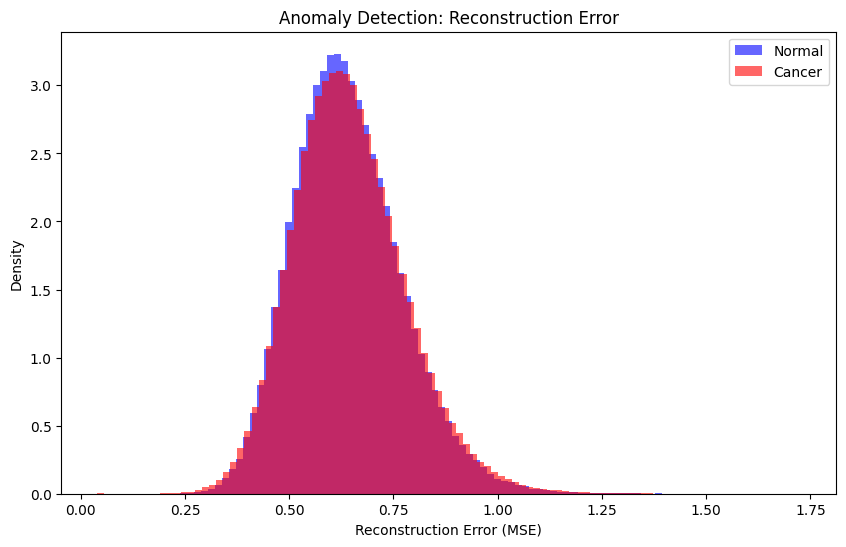

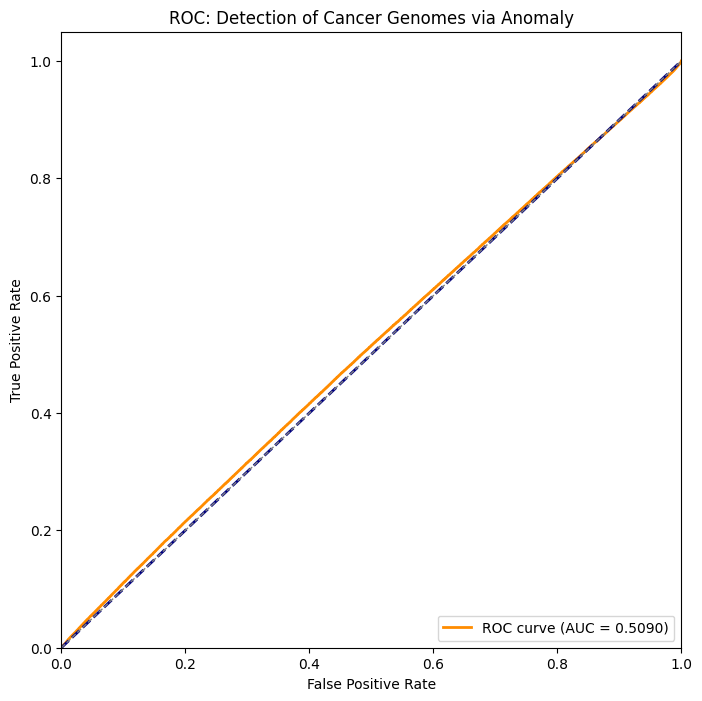


FINAL ANOMALY DETECTION AUC: 0.5090


In [ ]:
# --- FINAL FIX: LOAD WITHOUT COMPILING ---
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import drive
from tensorflow.keras.models import load_model
import tensorflow as tf

# 1. MOUNT DRIVE
print("Mounting Drive...")
drive.mount('/content/drive', force_remount=True)

# 2. CONFIG
BASE_DIR = '/content/drive/MyDrive/DNA_Anomaly_Detection'
CANCER_DIR = os.path.join(BASE_DIR, 'cancer_batches')
NORMAL_DIR = os.path.join(BASE_DIR, 'normal_batches')
MAX_LEN = 80

# 3. LOAD THE TRAINED MODEL (The Fix is here!)
model_path = os.path.join(BASE_DIR, 'lstm_autoencoder.h5')
if not os.path.exists(model_path):
    print("Main .h5 model not found. Checking for checkpoint...")
    model_path = os.path.join(BASE_DIR, "lstm_autoencoder_checkpoint.keras")

if not os.path.exists(model_path):
    raise ValueError(f"CRITICAL ERROR: No model found at {model_path}")

print(f"Loading model from: {model_path}")
# compile=False bypasses the "mse" error. We don't need to compile just to Predict.
autoencoder = load_model(model_path, compile=False)

# 4. LOAD CANCER DATA
print("\nLoading Cancer Data...")
cancer_files = sorted(glob.glob(os.path.join(CANCER_DIR, "*.npy")))
if not cancer_files:
    raise ValueError("No cancer data found! Check /cancer_batches/ folder.")

X_cancer_list = []
for f in cancer_files:
    X_cancer_list.append(np.load(f))
X_cancer = np.concatenate(X_cancer_list, axis=0)
X_cancer = X_cancer.reshape((X_cancer.shape[0], MAX_LEN, 1))
print(f"Cancer Data Loaded: {X_cancer.shape}")

# 5. LOAD NORMAL DATA
print("Loading Normal Data sample...")
normal_files = sorted(glob.glob(os.path.join(NORMAL_DIR, "*.npy")))
if not normal_files:
    raise ValueError("No normal data found! Check /normal_batches/ folder.")

# Load just the first batch to save RAM
X_val_normal = np.load(normal_files[0])
X_val_normal = X_val_normal.reshape((X_val_normal.shape[0], MAX_LEN, 1))
print(f"Normal Validation Data Loaded: {X_val_normal.shape}")

# 6. RUN PREDICTIONS
print("\nRunning Predictions (Approx 30-60s)...")
pred_normal = autoencoder.predict(X_val_normal, batch_size=512)
pred_cancer = autoencoder.predict(X_cancer, batch_size=512)

# 7. CALCULATE ERROR (MSE)
mse_normal = np.mean(np.square(X_val_normal - pred_normal), axis=1)
mse_cancer = np.mean(np.square(X_cancer - pred_cancer), axis=1)

print(f"\nMean Reconstruction Error (Normal): {np.mean(mse_normal):.4f}")
print(f"Mean Reconstruction Error (Cancer): {np.mean(mse_cancer):.4f}")

# 8. PLOT RESULTS
plt.figure(figsize=(10, 6))
plt.hist(mse_normal, bins=100, alpha=0.6, label='Normal', color='blue', density=True)
plt.hist(mse_cancer, bins=100, alpha=0.6, label='Cancer', color='red', density=True)
plt.title('Anomaly Detection: Reconstruction Error')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 9. ROC CURVE
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_cancer))])
y_scores = np.concatenate([mse_normal, mse_cancer])
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Detection of Cancer Genomes via Anomaly')
plt.legend(loc="lower right")
plt.show()

print(f"\nFINAL ANOMALY DETECTION AUC: {roc_auc:.4f}")

Mounted at /content/drive
DATA QUALITY DIAGNOSTICS

1. BASE DISTRIBUTION CHECK:
----------------------------------------
Normal batch:
  0: 2.50%
  1: 26.88%
  2: 21.75%
  3: 21.81%
  4: 26.90%
  5: 0.16%

Cancer batch:
  0: 2.50%
  1: 26.95%
  2: 21.31%
  3: 21.25%
  4: 27.17%
  5: 0.83%

2. SEQUENCE DIVERSITY:
----------------------------------------
Unique normal sequences: 199721/200000 (99.9%)
Unique cancer sequences: 199593/200000 (99.8%)

3. OVERLAP CHECK:
----------------------------------------
Identical sequences in both: 0/10000 (0.0%)


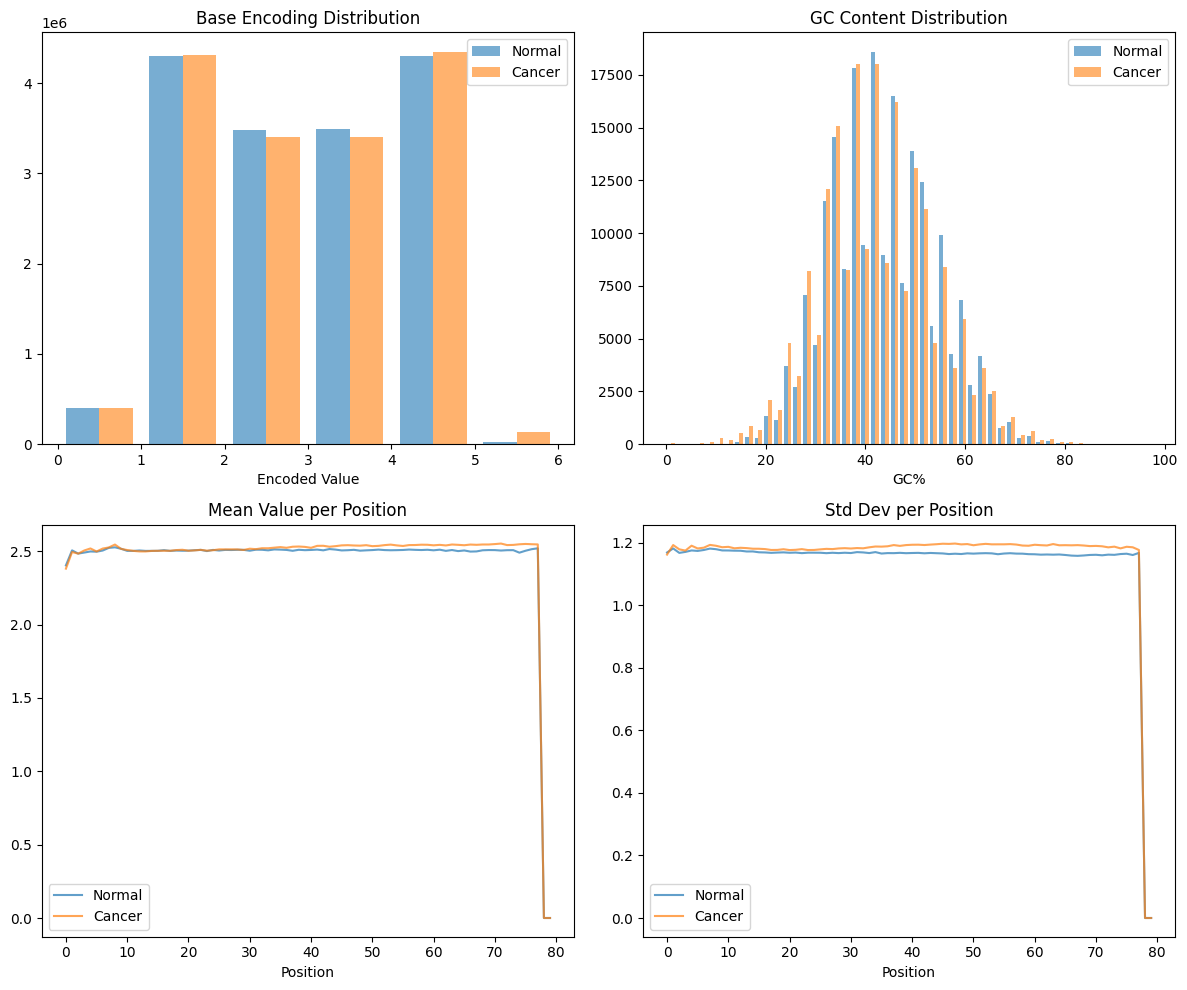


4. STATISTICAL COMPARISON:
----------------------------------------
T-test p-value: 0.000000
✓ Distributions are significantly different

5. DATA LOADING VERIFICATION:
----------------------------------------
Normal batch shape: (200000, 80)
Cancer batch shape: (200000, 80)
Expected shape: (N, 80)
Value range normal: 0-5
Value range cancer: 0-5


In [ ]:
"""
Run this to diagnose your data issues
"""

from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/DNA_Anomaly_Detection'

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load one normal and one cancer batch
normal_batch = np.load('/content/drive/MyDrive/DNA_Anomaly_Detection/normal_batches/normal_batch_1.npy')
cancer_batch = np.load('/content/drive/MyDrive/DNA_Anomaly_Detection/cancer_batches/cancer_batch_1.npy')

print("="*60)
print("DATA QUALITY DIAGNOSTICS")
print("="*60)

# 1. Check distributions
normal_flat = normal_batch.flatten()
cancer_flat = cancer_batch.flatten()

print("\n1. BASE DISTRIBUTION CHECK:")
print("-" * 40)
print("Normal batch:")
for base, count in sorted(Counter(normal_flat).items()):
    pct = (count / len(normal_flat)) * 100
    print(f"  {base}: {pct:.2f}%")

print("\nCancer batch:")
for base, count in sorted(Counter(cancer_flat).items()):
    pct = (count / len(cancer_flat)) * 100
    print(f"  {base}: {pct:.2f}%")

# 2. Check sequence diversity
print("\n2. SEQUENCE DIVERSITY:")
print("-" * 40)
normal_unique = len(set(map(tuple, normal_batch)))
cancer_unique = len(set(map(tuple, cancer_batch)))
print(f"Unique normal sequences: {normal_unique}/{len(normal_batch)} ({normal_unique/len(normal_batch)*100:.1f}%)")
print(f"Unique cancer sequences: {cancer_unique}/{len(cancer_batch)} ({cancer_unique/len(cancer_batch)*100:.1f}%)")

# 3. Check for overlap
print("\n3. OVERLAP CHECK:")
print("-" * 40)
normal_set = set(map(tuple, normal_batch[:10000]))  # Sample for speed
cancer_set = set(map(tuple, cancer_batch[:10000]))
overlap = len(normal_set & cancer_set)
print(f"Identical sequences in both: {overlap}/10000 ({overlap/100:.1f}%)")

# 4. Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Base distributions
axes[0,0].hist([normal_flat, cancer_flat], bins=range(0, 7), alpha=0.6, label=['Normal', 'Cancer'])
axes[0,0].set_title('Base Encoding Distribution')
axes[0,0].set_xlabel('Encoded Value')
axes[0,0].legend()

# GC content
normal_gc = np.mean((normal_batch == 2) | (normal_batch == 3), axis=1) * 100
cancer_gc = np.mean((cancer_batch == 2) | (cancer_batch == 3), axis=1) * 100
axes[0,1].hist([normal_gc, cancer_gc], bins=50, alpha=0.6, label=['Normal', 'Cancer'])
axes[0,1].set_title('GC Content Distribution')
axes[0,1].set_xlabel('GC%')
axes[0,1].legend()

# Mean per position
axes[1,0].plot(normal_batch.mean(axis=0), label='Normal', alpha=0.7)
axes[1,0].plot(cancer_batch.mean(axis=0), label='Cancer', alpha=0.7)
axes[1,0].set_title('Mean Value per Position')
axes[1,0].set_xlabel('Position')
axes[1,0].legend()

# Std per position
axes[1,1].plot(normal_batch.std(axis=0), label='Normal', alpha=0.7)
axes[1,1].plot(cancer_batch.std(axis=0), label='Cancer', alpha=0.7)
axes[1,1].set_title('Std Dev per Position')
axes[1,1].set_xlabel('Position')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# 5. Statistical test
from scipy import stats
print("\n4. STATISTICAL COMPARISON:")
print("-" * 40)
# Compare means across all positions
t_stat, p_value = stats.ttest_ind(normal_batch.mean(axis=1), cancer_batch.mean(axis=1))
print(f"T-test p-value: {p_value:.6f}")
if p_value > 0.05:
    print("⚠️  WARNING: Distributions are NOT significantly different!")
else:
    print("✓ Distributions are significantly different")

# 6. Check for data leakage
print("\n5. DATA LOADING VERIFICATION:")
print("-" * 40)
print(f"Normal batch shape: {normal_batch.shape}")
print(f"Cancer batch shape: {cancer_batch.shape}")
print(f"Expected shape: (N, 80)")
print(f"Value range normal: {normal_batch.min()}-{normal_batch.max()}")
print(f"Value range cancer: {cancer_batch.min()}-{cancer_batch.max()}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load Data (If not already in memory) ---
# Assuming you have already run the model inference and have 'mse_normal' and 'mse_cancer'
# If variables are lost, you would need to reload your test set and model, then predict:
# test_normal_preds = autoencoder.predict(test_normal_seqs)
# mse_normal = np.mean(np.square(test_normal_seqs - test_normal_preds), axis=1)
# test_cancer_preds = autoencoder.predict(test_cancer_seqs)
# mse_cancer = np.mean(np.square(test_cancer_seqs - test_cancer_preds), axis=1)

# --- 2. Generate Histogram Plot ---
plt.figure(figsize=(10, 6))

# Plot Normal (Blue)
sns.histplot(mse_normal, color="blue", label="Normal Samples", kde=True, stat="density", bins=50, alpha=0.5)

# Plot Cancer (Red)
sns.histplot(mse_cancer, color="red", label="Cancer Samples", kde=True, stat="density", bins=50, alpha=0.5)

# --- 3. Styling ---
plt.title("Reconstruction Error Distribution (Normal vs. Cancer)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# --- 4. Save and Show ---
# Save high-res version for your report
plt.savefig('reconstruction_error_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("Histogram saved as 'reconstruction_error_histogram.png'. Please download this file.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load Data (If not already in memory) ---
# Assuming you have already run the model inference and have 'mse_normal' and 'mse_cancer'
# If variables are lost, you would need to reload your test set and model, then predict:
test_normal_preds = autoencoder.predict(test_normal_seqs)
mse_normal = np.mean(np.square(test_normal_seqs - test_normal_preds), axis=1)
test_cancer_preds = autoencoder.predict(test_cancer_seqs)
mse_cancer = np.mean(np.square(test_cancer_seqs - test_cancer_preds), axis=1)

# --- 2. Generate Histogram Plot ---
plt.figure(figsize=(10, 6))

# Plot Normal (Blue)
sns.histplot(mse_normal, color="blue", label="Normal Samples", kde=True, stat="density", bins=50, alpha=0.5)

# Plot Cancer (Red)
sns.histplot(mse_cancer, color="red", label="Cancer Samples", kde=True, stat="density", bins=50, alpha=0.5)

# --- 3. Styling ---
plt.title("Reconstruction Error Distribution (Normal vs. Cancer)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# --- 4. Save and Show ---
# Save high-res version for your report
plt.savefig('reconstruction_error_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("Histogram saved as 'reconstruction_error_histogram.png'. Please download this file.")

NameError: name 'test_normal_seqs' is not defined